<a href="https://colab.research.google.com/github/minyoy/ML-DL-Basics-study/blob/main/wk6/basic_wk6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6주차: Multi-layer Perceptron (2)**

In [ ]:
# install package
!pip install torch
!pip install torchvision

## **모델 학습시에 발생할 수 있는 문제**

#### **과적합 및 과소적합 (Overfitting & Underfitting)**

<img src="https://velog.velcdn.com/images%2Fjoo4438%2Fpost%2Fc759a5f6-d3c5-4c33-ade9-78c4cfec4b85%2Fimage.png" width="500"> </br> </br>

과적합은 모델이 학습 데이터에 지나치게 맞추어진 상태로, 학습 데이터에는 좋은 성능을 보이나 새로운 데이터에서는 좋은 성능을 보이지 못하는 현상

주로 학습 데이터의 크기에 비해 상대적으로 모델이 크거나 학습을 오래 시킨 경우 발생함 </br> </br>

과소적합은 모델이 학습 데이터를 충분히 학습하지 못한 상태로, 학습 데이터와 새로운 데이터에서 모두 좋은 성능을 보이지 못하는 현상

주로 학습 데이터의 크기에 비해 상대적으로 모델이 작거나 학습을 적게 시킨 경우 발생함

#### **기울기 소실 및 폭주 (Gradient Vanishing & Exploding)**

<img src="https://ifh.cc/g/OOgT8R.jpg" width=400> </br> </br>

기울기 소실은 역전파 과정에서 기울기가 점차 작아져 입력층에 가까운 층들의 가중치가 제대로 업데이트 되지 않는 현상

주로 은닉층을 많이 가지고, 시그모이드나 tanh와 같은 값이 포화되는 활성화 함수를 사용할 때 많이 발생함 </br> </br>


기울기 폭주는 역전파 과정에서 기울기가 점점 커지면서 모델의 가중치가 비정상적으로 큰 값으로 발산하는 현상

주로 은닉층을 많이 가지고, 각 층의 가중치 값이나 학습률이 지나치게 클 때 많이 발생함

**기울기 소실 예시**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0) # 난수 시드(seed)를 고정해 매번 같은 난수(모델 초기화, 입력 등)를 생성하도록

num_layers = 5
model = nn.Sequential(*[nn.Sequential(nn.Linear(5,5), nn.Sigmoid()) for _ in range(num_layers)])
"""
동일한 구조(Linear(5,5) + Sigmoid)를 5번 반복한 모델로 아래와 같음
(0): Linear(5 → 5) + Sigmoid
(1): Linear(5 → 5) + Sigmoid
(2): Linear(5 → 5) + Sigmoid
(3): Linear(5 → 5) + Sigmoid
(4): Linear(5 → 5) + Sigmoid
"""

x = torch.randn(1,5) # x: 입력 데이터 (shape = [1,5])
x_true = torch.zeros_like(x) # x_true: 목표 출력 (모두 0으로 구성된 [1,5] 텐서)

x_pred = model(x)
loss = F.mse_loss(x_pred, x_true) # MSE 손실 사용, 여기선 x_true = 0이므로 단순히 x_pred 값의 제곱 평균이 됨

loss.backward() # 역전파, 손실을 기준으로 모든 가중치에 대한 기울기(gradient) 계산

for i in range(num_layers):
    # L2 norm (유클리드 거리)로, 각 Linear 층 가중치의 gradient 크기 출력
    print(f"Layer {i} weight's gradient norm: {torch.norm(model[i][0].weight.grad)}")

# 결과를 보면 입력 가까운 층일수록 gradient가 작아짐 (학습이 거의 안 됨)

Layer 0 weight's gradient norm: 2.585166657809168e-05
Layer 1 weight's gradient norm: 0.0001902711228467524
Layer 2 weight's gradient norm: 0.0012359083630144596
Layer 3 weight's gradient norm: 0.008981738239526749
Layer 4 weight's gradient norm: 0.11240576207637787


**기울기 폭주 예시**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

num_layers = 5
model = nn.Sequential(*[nn.Sequential(nn.Linear(5,5), nn.ReLU()) for _ in range(num_layers)])
"""
동일한 구조(Linear(5 → 5) + ReLU)를 5번 반복한 모델로 아래와 같음
(0): Linear(5→5) + ReLU
(1): Linear(5→5) + ReLU
(2): Linear(5→5) + ReLU
(3): Linear(5→5) + ReLU
(4): Linear(5→5) + ReLU
"""

for _ in range(3):
    x = torch.randn(1,5)
    x_true = torch.randn_like(x)

    x_pred = model(x)
    loss = F.mse_loss(x_pred, x_true)

    model.zero_grad() # 이전 단계의 gradient를 0으로 초기화
    loss.backward()

    for param in model.parameters():
        param.data -= 100 * param.grad
        # 모든 파라미터(가중치, 편향)에 대해 기울기 방향의 반대로 업데이트
        # 학습률(learning rate)을 100으로 인위적으로 크게 설정해서 변화가 확실하게 보이도록 함

for i in range(num_layers):
    # 각 layer의 Linear weight에 대한 gradient의 L2 norm 출력.
    print(f"Layer {i} weight's gradient norm: {torch.norm(model[i][0].weight.grad)}")

# 결과를 보면 gradient가 매우 큰 것을 알 수 있음

Layer 0 weight's gradient norm: 960845.5
Layer 1 weight's gradient norm: 13042640896.0
Layer 2 weight's gradient norm: 10315294720.0
Layer 3 weight's gradient norm: 497055136.0
Layer 4 weight's gradient norm: 89344540672.0


## **모델 학습 기술**

과적합 및 과소적합으로 모델의 성능이 저하될 수 있고, 기울기 소실 및 폭주로 모델이 제대로 학습되지 않을 수 있음

이러한 문제들을 막기 위해서 사용할 수 있는 여러가지 기술들이 존재하며, 이를 이해하고 적절히 활용하여 모델을 안정적으로 학습시키고 성능을 최적화하는 것이 중요함

### **모델 크기 조절**

데이터셋의 크기에 비해 모델의 크기가 크다면 과소적합이 일어날 가능성이 있고,

데이터셋의 크기에 비해 모델의 크기가 작다면 반대로 과적합이 일어날 가능성이 있음 </br> </br>

<img src="https://i.ibb.co/XFV7mhF/2024-01-06-6-26-09.png" width="350"> </br> </br>

따라서, 데이터셋의 크기에 따라 모델의 크기를 적절하게 결정하는 것이 중요하며,

은닉층의 개수, 은닉층의 노드 개수 등을 조정하여 모델의 크기를 조절할 수 있음

### **규제 (Regulatization)**

규제는 모델이 학습 데이터의 노이즈나 불필요한 패턴을 학습하는 것을 방지함으로써 과적합을 막는 기법을 의미하며,

모델이 복잡해지는 것을 막고 새로운 데이터에서도 좋은 성능을 보이는 일반화 (Generalization) 능력을 향상시키는 것을 목표로 함

#### **L1 규제 (L1 Regularization)**

모델이 데이터를 더욱 구체적이고 민감하게 학습하면 가중치가 커지기 때문에,

손실 함수에 모델의 가중치 절대값 합을 페널티 텀으로 주어 가중치의 크기를 줄여 과적합을 막는 방법 </br> </br>

$L_{reg} = L(y_{i}, \hat{y_{i}}) + \lambda \sum_{i} |w_{i}|$

<span style="font-size: 13px">

$L$ : 손실함수 &#160;&#160; $y_{i}$ : 실제값 &#160;&#160; $\hat{y_{i}}$ : 모델의 예측값 &#160;&#160; $w$ : 모델의 가중치 &#160;&#160; $\lambda$: 규제 강도

</span>

**L1 규제 예시**

In [ ]:
import torch
import torch.nn as nn

num_layers = 5
model = nn.Sequential(*[nn.Sequential(nn.Linear(5,5), nn.ReLU()) for _ in range(num_layers)])

x = torch.randn(1,5)
x_true = torch.zeros_like(x)

x_pred = model(x)
loss = F.mse_loss(x_pred, x_true)

gamma = 0.01 # 규제 강도
l1_norm = torch.stack([torch.norm(param.data, p=1) for name, param in model.named_parameters() if "weight" in name]).sum() # weight의 절댓값 합
loss += gamma * l1_norm

loss.backward()     # backpropagation with l1 regularization

#### **L2 규제 (L2 Regularization)**

모델이 데이터를 더욱 구체적이고 민감하게 학습하면 가중치가 커지기 때문에,

손실 함수에 모델의 가중치 제곱합을 페널티 텀으로 주어 가중치의 크기를 줄여 과적합을 막는 방법 </br> </br>

$L_{reg} = L(y_{i}, \hat{y_{i}}) + \lambda \sum_{i} w^{2}_{i}$

<span style="font-size: 13px">

$L$ : 손실함수 &#160;&#160; $y_{i}$ : 실제값 &#160;&#160; $\hat{y_{i}}$ : 모델의 예측값 &#160;&#160; $w$ : 모델의 가중치 &#160;&#160; $\lambda$: 규제 강도

</span>

**L2 규제 예시**

In [ ]:
import torch
import torch.nn as nn

num_layers = 5
model = nn.Sequential(*[nn.Sequential(nn.Linear(5,5), nn.ReLU()) for _ in range(num_layers)])

x = torch.randn(1,5)
x_true = torch.zeros_like(x)

x_pred = model(x)
loss = F.mse_loss(x_pred, x_true)

gamma = 0.01 # 규제 강도
l2_norm = sum([torch.norm(param.data, p=2) for name, param in model.named_parameters() if "weight" in name]) # weight의 제곱 합
loss += gamma * l2_norm

loss.backward()     # backpropagation with l2 regularization

#### **L1 규제 및 L2 규제 비교**

L1 규제는 특정 가중치를 0으로 만들 수 있어 중요한 특성을 선택하는 효과가 있고, 또한 모델의 복잡도를 낮출 수 있음

반면에 L2 규제는 가중치를 0에 가깝게 줄여주지만 완전히 0으로 만들지는 못하며, 전체 가중치 크기를 균형 있게 줄이는 역할을 함 </br> </br>

<img src="https://t1.daumcdn.net/cfile/tistory/99BED3425CE4B13418" width="400">  </br> </br>

일반적으로 L2 규제가 L1 규제보다 안정적이고 일관된 성능을 제공하며, 학습할 데이터와 모델에 따라 적절히 선택하는 것이 중요함

#### **가중치 감쇠 (Weight Decay)**

모델이 데이터를 더욱 구체적이고 민감하게 학습하면 가중치가 커지기 때문에,

가중치를 일정 부분 감쇠함으로써 가중치가 너무 커지지 않도록 조절하여 과적합을 막는 방법 </br> </br>

$ w_{t} = w_{t-1} - \mu (\frac{\partial L}{\partial w_{t-1}} + \lambda w_{t-1}) $

<span style="font-size: 13px">

$L$ : 손실함수 &#160;&#160; $w$ : 모델의 가중치 &#160;&#160; $\mu$ : 학습률 &#160;&#160; $\lambda$ : 가중치 감쇠 계수

</span>
</br>

SGD, Momentum과 같은 옵티마이저에서는 가중치 감쇠가 L2 규제와 동일하게 작동하는 특징을 가짐

**가중치 감쇠 예시**

In [ ]:
import torch
import torch.nn as nn

model = nn.Sequential(*[nn.Sequential(nn.Linear(5,5), nn.ReLU()) for _ in range(num_layers)])
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)    # weight decay argument in optimizer
# 학습률 0.01, L2 정규화 계수 (λ) 0.0001

x = torch.randn(1,5)
x_true = torch.zeros_like(x)

x_pred = model(x)
loss = F.mse_loss(x_pred, x_true)

optim.zero_grad()
loss.backward()
optim.step()    # apply weight decay with parameter update

### **그래디언트 클리핑 (Gradient Clipping)**

역전파 과정에서 각 파라미터 기울기의 크기가 일정 임계값을 넘어가면 기울기 값을 임계값에 맞춰 자르는 방법 </br> </br>

<img src="https://dajeblog.co.kr/wp-content/uploads/2024/09/image-optimized.png" width=300> </br> </br>

$ \hat{g_{i}} = \begin{cases}
  \frac{threshold}{\vert\vert \hat{g_{i}} \vert\vert} \hat{g_{i}} \;\;\;\; if \; ||\hat{g_{i}}|| \geq threshold \\
  \;\;\;\;\; \hat{g_{i}}  \;\;\;\;\;\;\;\;\;\; otherwise \end{cases} $

<span style="font-size: 13px">

$\hat{g}$ : 파라미터의 기울기 &#160;&#160; $threshold$ : 기울기 임계값

</span>
</br>

극단적인 기울기를 일정범위로 제한함으로써 신경망 학습 도중에 발생할 수 있는 기울기 폭주 문제를 막고,

모델이 안정적으로 학습을 할 수 있도록 도움을 줌

**그래디언트 클리핑 예시**

In [ ]:
import torch
import torch.nn as nn

model = nn.Sequential(*[nn.Sequential(nn.Linear(5,5), nn.ReLU()) for _ in range(num_layers)])

x = torch.randn(1,5)
x_true = torch.zeros_like(x)

x_pred = model(x)
loss = F.mse_loss(x_pred, x_true)

loss.backward()
nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)    # gradinet clipping

tensor(0.1175)

### **가중치 초기화 (Weight Intialization)**

가중치 초기화는 모델을 학습시키기 전에 모델의 초기 가중치를 설정하는 과정으로,

초기 가중치 설정에 따라 모델을 학습시켰을 때 성능이 달라질 수도 있고, 수렴 속도와 안정성에도 영향을 주기 때문에 중요함 </br> </br>

<img src="https://miro.medium.com/max/1225/1*t4aYsxpCqz2eymJ4zkUS9Q.png" width="400">

#### **모두 동일한 값으로 가중치를 초기화한다면?**

역전파 과정에서 각 가중치들이 동일한 기울기를 가지게 되고, 그 결과 각 가중치들이 동일하게 업데이트 됨

이러한 과정이 반복되면서 최종적으로 각 가중치들이 동일한 값을 가지게 되는 문제가 발생하는데, 이를 대칭성 문제라고 함

따라서, 동일한 값이 아닌 난수로 가중치를 설정하여 대칭성 문제를 해결할 수 있음

#### **아주 작은 난수로 가중치를 초기화한다면?**

<img src="https://velog.velcdn.com/images%2Fcha-suyeon%2Fpost%2Fac42eb4a-5e85-47bf-a531-3648f68a77cf%2Fimage.png" width=400>

가중치가 아주 작은 난수로 초기화된다면, 입력값이 각 층을 지날수록 활성화함수를 지나기 전 출력값이 점점 0에 수렴하게 됨

이는 기울기 소실 문제를 일으키게 되고, 모두 비슷한 출력값으로 인해 모든 가중치가 비슷하게 학습되는 대칭성 문제를 일으킬 수 있음

따라서, 최종적으로 모델의 가중치가 제대로 업데이트 되지 않는 결과를 가져옴

#### **아주 큰 난수로 가중치를 초기화하면?**

<img src="https://velog.velcdn.com/images%2Fcha-suyeon%2Fpost%2Fa19fca56-9b38-488f-9722-708c9e0922a4%2Fimage.png" width=400>

가중치가 아주 큰 난수로 초기화된다면, 입력값이 각 층을 지날수록 활성화함수를 지나기 전 출력값이 발산하게 됨

이는 활성화함수에 따라 기울기 소실 문제나 기울기 폭주 문제를 일으킬 수 있어, 모델이 제대로 학습되지 않을 수 있음

#### **그러면 어떻게 가중치 초기화를 해야할까?**

기울기 소실 및 폭주 문제, 대칭성 문제가 일어나는 것을 막고 모델이 안정적으로 학습되기 위해서는

각 층의 출력값이 광범위하게 분포되어 있어야 하는데, 이는 각 층의 출력값의 분산이 중요한 역할임을 뜻함 </br> </br>

$ Var(\sum^{n}_{i} {w_{i}{x_{i}}}) = n Var(w) Var(x) = Var(\sqrt{n} w) Var(x) \;\; \leftarrow E(w) = 0 $

<span style="font-size: 13px">

$w$ : 모델의 가중치 &#160;&#160; $x$ : 입력값 &#160;&#160; $n$ : 입력값의 개수 (노드의 개수)

</span>

각 층에서 출력값의 분산은 입력값의 수(노드의 수)와 비례하기 때문에, 각 층의 노드의 수를 이용하여 난수로 생성된 가중치를 스케일링 해줄 수 있음 </br> </br>

In [ ]:
import math
import torch

h_dim = 100
weight = torch.randn(h_dim,h_dim) / math.sqrt(h_dim)

이를 이용하여 가중치 초기화를 진행하면 학습 초기에 입력값의 분산과 출력값의 분산을 비슷하게 설정할 수 있는데,

시그모이드나 tanh 활성화함수에서는 Xavier Intailization (Glorot Intialization)을, ReLU 활성화함수에서는 He Initialization (Kaiming Intialization)을 주로 이용함

#### **Xavier Initialization (Glorot Intialization)**

각 층의 가중치를 그 층의 입력 노드 수와 출력 노드 수에 기반하여 조절된 분산을 가진 분포에서 무작위로 선택하여 가중치를 초기화하는 방법

이전 층의 노드 수가 $n_{in}$ 이고 다음 층의 노드 수가 $n_{out}$ 일 때, 표준편차가 $ \sqrt{\frac {2} {n_{in}+n_{out}}} $인 분포 이용 </br> </br>

<img src="https://velog.velcdn.com/images%2Fcha-suyeon%2Fpost%2F7372914e-d761-422e-a708-19f184532208%2Fimage.png" width=400> </br> </br>

Xavier 초기화에서는 활성화 함수가 선형 함수인 것을 전제로 하기 때문에, 주로 시그모이드나 tanh 함수와 같이 선형성을 띠는 구간이 있는 활성화 함수를 사용하는 모델에 적합하며,

입력값과 출력값의 분산을 같아지게 설계되어 있어 깊은 층에서도 효과적인 학습을 도움 </br> </br>

<img src="https://velog.velcdn.com/images%2Fcha-suyeon%2Fpost%2Fb699ec29-15bb-4556-bba3-4bf2b170dca8%2Fimage.png" width=400> </br> </br>

Xavier 초기화는 정규 분포 (Normal Distribution)을 이용한 방법과 균등 분포 (Uniform Distribution)을 이용한 방법이 있음

**Xavier Intialization 예시**

In [ ]:
import torch.nn as nn

num_layers = 5
model = nn.Sequential(*[nn.Sequential(nn.Linear(5,5), nn.Sigmoid()) for _ in range(num_layers)])

# 모델 내부의 모든 Linear layer를 찾아서 각 weight 텐서에 대해 Xavier 초기화를 적용
# isinstance(module, nn.Linear); module이 nn.Linear 타입(클래스)인지 True/False로 판별하는 조건문
for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)     # xavier intialization (uniform)

#### **He Initialization (Kaiming Intialization)**

He 초기화는 ReLU 함수와 같은 활성화 함수와 함께 사용하기 위해 만들어진 가중치 초기화 방법으로,

이전 층의 노드 수가 $n_{in}$ 일 때, 표준편차가 $ \sqrt{\frac {2} {n_{in}}} $인 분포 이용 </br> </br>

ReLU 함수는 음수값을 모두 0으로 바꾸는 특징을 가지고 있어 출력값의 분산이 시그모이드나 tanh 활성화함수에 비해서 약 2배 정도 줄어들기 때문에,

Xavier 초기화의 분산보다 약 2배 정도 크게 설정하여 줄어든 출력값의 분산을 보상하는 방식으로 가중치 초기화를 진행하는 방식임 </br> </br>

<img src="https://velog.velcdn.com/images%2Fcha-suyeon%2Fpost%2F401dada6-3a5d-438b-98c1-d53db0a68bb6%2Fimage.png" width=400> </br> </br>

He 초기화는 정규 분포 (Normal Distribution)을 이용한 방법과 균등 분포 (Uniform Distribution)을 이용한 방법이 있음

**He Initialization 예시**

In [ ]:
import torch.nn as nn

num_layers = 5
model = nn.Sequential(*[nn.Sequential(nn.Linear(5,5), nn.ReLU()) for _ in range(num_layers)])

for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight, nonlinearity="relu")     # he intialization (uniform)

### **특성 정규화 (Feature Normalization)**

각 층의 출력값의 분포를 평균과 분산을 이용하여 조정하는 기법으로,

은닉층에서 활성화 함수를 지니기 전에 특성 정규화를 적용하는 방식으로 사용함 </br> </br>

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*onZIiGguLfbUYs3aTtmijg.jpeg" width="400"> </br> </br>

특성 간의 크기나 범위 차이로 발생할 수 있는 문제를 막아주고 각 층의 출력값을 특정 분포에 놓이게 만드는 역할을 하며,

이는 모델의 수렴 속도를 증가시키고 학습을 안정화하여 가중치 초기화에 덜 민감하게 만들어줌

#### **배치 정규화 (Batch Normalization)**

미니배치 단위로 정규화를 수행하는 기법으로,

미니배치에서 각 특성 별로 평균과 분산을 계산하여 정규 분포로 만들어줌 </br> </br>

<img src="https://production-media.paperswithcode.com/methods/batchnorm.png" width="150"> </br> </br>

$ BN(X) = \gamma (\dfrac {X-\mu}{\sigma}) + \beta $

<span style="font-size: 13px">

$X$ : 입력값 &#160;&#160; $\mu$ : 미니배치의 특성별 평균 &#160;&#160; $\sigma$ : 미니배치의 특성별 표준편차 &#160;&#160; $\gamma$ : scale 파라미터 &#160;&#160; $\beta$ : shift 파라미터

</span>
</br>

$\gamma$와 $\beta$는 학습 가능한 파라미터로,

계산된 각 특성별 표준 정규 분포를 모델에게 적절한 분포로 조정할 수 있게끔 도와주는 역할을 함 </br> </br>

그리고 $\mu$와 $\sigma$는 학습 과정과 평가 과정에서 각각 다르게 작동하는데,

학습 과정에서는 모델에 들어오는 미니배치의 평균($\mu_{batch}$)과 표준편차($\sigma_{batch}$)를 사용하지만,

평가 과정에서는 학습 과정에서 계산된 미니배치들의 이동 평균($\mu_{BN}$)과 표준편차($\sigma_{BN}$)을 사용함

이는 모델에 들어오는 한 미니배치의 평균과 표준편차보다는 미니배치들의 이동 평균과 표준편차가 전체 데이터의 분포에 가깝기 때문임 </br> </br>

배치 정규화는 미니배치의 각 특성별로 정규화를 진행하기 때문에,

여러 특성들이 서로 관여하지 않고 독립적인 특성을 유지할 수 있도록 하는 장점이 있고,

들어오는 미니배치별로 평균과 분산이 계속해서 달라지기 때문에 과적합을 방지하는데 도움을 줌 </br> </br>

하지만, 미니배치 크기가 작으면 계산되는 평균과 분산이 불안정하기 때문에 미니배치 크기에 의존적이고,

학습 과정에서 미니배치들의 이동 평균과 표준편파를 계산하고 저장해야 된다는 단점이 있음

또한, 시점이 있는 순차 데이터에서는 각 시점간의 관계를 무시해버리기 때문에 적용하기 어려움

따라서, MLP나 CNN과 같은 모델에서 주로 사용함


**배치 정규화 예시**

In [ ]:
import torch
import torch.nn as nn

# 입력 텐서의 feature dimension이 5
# 1d는 fully-connected (dense) layer나 sequence feature용 배치 정규화 (Conv 레이어용은 BatchNorm2d)
batch_norm = nn.BatchNorm1d(5)
x = torch.randn(100,5)

# 각 feature(열)마다 BN 계산
normalized_x = batch_norm(x)

for i in range(5):
    mean, var = normalized_x[:,i].mean(), normalized_x[:,i].var()
    print(f"feature {i} |  mean: {mean}  variance:{var}")

# 각 feature마다 평균 ≈ 0, 분산 ≈ 1로 정규화된 걸 확인할 수 있음
# 마지막 결과는 배치의 크기가 상대적으로 작아서 평균에 작은 오차나 튐(jitter) 이 생긴 사례

feature 0 |  mean: -1.668930060816365e-08  variance:1.01009202003479
feature 1 |  mean: -2.8610228852699038e-08  variance:1.0100905895233154
feature 2 |  mean: 0.0  variance:1.0100905895233154
feature 3 |  mean: 0.0  variance:1.0100915431976318
feature 4 |  mean: 9.53674295089968e-09  variance:1.0100899934768677


#### **층 정규화 (Layer Normalization)**

각 층 단위로 정규화를 수행하는 기법으로,

하나의 데이터에 대해서 모든 특성값들의 평균과 분산을 계산하여 정규 분포로 만들어줌 </br> </br>

<img src="https://ifh.cc/g/jXomQP.jpg" width=150> </br> </br>

$ LN(X) = \gamma (\dfrac {X-\mu}{\sigma}) + \beta $

<span style="font-size: 13px">

$X$ : 입력값 &#160;&#160; $\mu$ : 각 입력값의 평균 &#160;&#160; $\sigma$ : 각 입력값의 표준편차 &#160;&#160; $\gamma$ : scale 파라미터 &#160;&#160; $\beta$ : shift 파라미터

</span>
</br>

$\gamma$와 $\beta$는 학습 가능한 파라미터로,

한 데이터 내의 특성 간의 중요도를 조정하고, 각 데이터를 모델에게 적절한 분포로 변환시킬 수 있게 도와주는 역할을 함</br> </br>

층 정규화는 각 데이터별로 정규화를 진행하기 때문에

배치 크기에 의존하지 않아 작은 배치 크기에서도 안정적인 학습이 가능하며,

시점이 있는 순차 데이터에서는 시간적 특성을 잘 보존할 수 있기 때문에 유리함

따라서, RNN이나 Transformer와 같은 모델에서 주로 사용함 </br> </br>

하지만, 배치 정규화에 비해 따로 규제 효과는 없고 각 특성 간의 일관된 정규화 패턴을 만들어내기는 어려우며,

특성 수가 적은 데이터나 모델에서는 잘 작동하지 않을 수 있음

**층 정규화 예시**

In [ ]:
import torch
import torch.nn as nn

# 입력 feature dimension이 100일 때, feature가 아닌 sample별로 정규화가 일어남
layer_norm = nn.LayerNorm(100)
x = torch.randn(5,100)

normalized_x = layer_norm(x) # 각 데이터(행)마다 평균과 분산을 계산하여 정규화

for i in range(5):
    mean, var = normalized_x[i,:].mean(), normalized_x[i,:].var()
    print(f"data {i} |  mean: {mean}  variance:{var}")

# 각 데이터는 평균이 거의 0, 분산은 거의 1

data 0 |  mean: 1.0728836485895954e-08  variance:1.0100915431976318
data 1 |  mean: 2.1457672971791908e-08  variance:1.0100901126861572
data 2 |  mean: -1.5497207073167374e-08  variance:1.0100913047790527
data 3 |  mean: -1.668930060816365e-08  variance:1.0100940465927124
data 4 |  mean: -1.907348590179936e-08  variance:1.0100871324539185


### **드롭아웃 (Dropout)**

학습 과정에서 모델의 전체 노드 중에서 일부 노드를 비활성화하는 기법으로,

무작위로 일부 노드를 샘플링한 후에 선택된 노드의 출력값을 0으로 변경하는 방식으로 작동하며,

주로 은닉층에서 많이 사용하고, 활성화함수 뒤에 드롭아웃을 적용하는 방식으로 활용함 </br> </br>

<img src="https://miro.medium.com/max/981/1*EinUlWw1n8vbcLyT0zx4gw.png" width="400"> </br> </br>

학습 과정에서 각 iteration별로 무작위로 노드(특성)들을 비활성화 하기 때문에

모델이 특정 노드(특성)들에 과도하게 의존하지 않고 모든 특성들이 독립적으로 유용한 특성이 될 수 있도록 만드는 효과가 있으며,

여러 서로 다른 서브 모델을 학습시키는 것과 동일하게 만들어 앙상블 학습과 유사한 효과를 보여줌

이러한 효과로 인해 과적합을 방지할 수 있으며, 간단하게 구현이 가능하고 여러 모델에 광범위하게 사용할 수 있어 효율적임 </br> </br>

<img src="https://i.ibb.co/3cQwx0t/2024-11-02-1-31-34.png" width=400>

하지만, 평가 과정에서는 모델의 모든 노드들이 활성화되기 때문에 학습 과정과 평가 과정에서의 출력값의 스케일이 서로 다름

따라서, 학습 과정과 평가 과정에서 드롭아웃 층은 서로 다르게 작동이 되어야 하는데,

드롭아웃 확률($p$)을 이용하여 학습 과정에서의 출력값과 평가 과정에서의 출력값의 스케일을 맞춰줘야 함 </br> </br>

평가 과정에서 출력값의 스케일을 맞춰주는 Vanilla Dropout과 학습 과정에서 출력값의 스케일을 맞춰주는 Inverted Dropout이 존재함

#### **Vanilla Dropout**

평가 과정에서 출력값의 스케일을 맞춰주는 드롭아웃 기법으로,

학습 과정에서는 드롭아웃이 적용된 출력값을 그대로 사용하고, 평가 과정에서는 출력값에 드롭아웃 확률($p$)을 곱하여 사용함 </br> </br>

$ m_{i} = \begin{cases}
  0 \;\;\;\; \text{with probability} \;\; p \\
  1 \;\;\;\; \text{with probability} \;\; (1 - p) \end{cases}$

$ \text{Dropout}(x_{i}) = \begin{cases}
  m_{i} x_{i} \;\;\;\; \text{if train} \\
  \; x_{i} p \;\;\;\;\; \text{elif test} \end{cases}$

<span style="font-size: 13px">

$x_{i}$ : $i$번째 입력값 &#160;&#160; $p$ : 드롭아웃 확률

</span>

#### **Inverted Dropout**

학습 과정에서 출력값의 스케일을 맞춰주는 드롭아웃 기법으로,

학습 과정에서는 드롭아웃이 적용된 출력값에 드롭아웃 확률($p$)을 나누어 사용하고, 평가 과정에서는 출력값을 그대로 사용함 </br> </br>

$ m_{i} = \begin{cases}
  0 \;\;\;\; \text{with probability} \;\; p \\
  1 \;\;\;\; \text{with probability} \;\; (1 - p) \end{cases}$

$ \text{Dropout}(x_{i}) = \begin{cases}
  \dfrac{m_{i} x_{i}}{p} \;\;\;\; \text{if train} \\
  \;\;\; x_{i} \;\;\;\;\;\; \text{elif test} \end{cases}$

<span style="font-size: 13px">

$x_{i}$ : $i$번째 입력값 &#160;&#160; $p$ : 드롭아웃 확률

</span>
</br>

Vanilla Dropout보다 계산적인 면에서 효율적이기 때문에 더 많이 사용되는 방식임

**Inverted Dropout 예시**

In [ ]:
import torch
import torch.nn as nn

dropout = nn.Dropout(p=0.5) # 50% 확률로 각 입력 요소를 0으로 만듬
x = torch.ones((1,10)) # [1,10] 텐서, 10개의 feature 값이 모두 1

dropout.train() # 훈련 모드로 설정
train_x = dropout(x) # 절반 정도가 0으로 꺼지고, 살아남은 1들은 2(=1/(1-0.5))로 보정

dropout.eval() # 평가(테스트) 모드로 설정
test_x = dropout(x) # 모든 뉴런이 켜지고 스케일링도 하지 않음

print(f"before dropout: {x}")
print(f"after dropout (train): {train_x}")
print(f"after dropout (test): {test_x}")

before dropout: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
after dropout (train): tensor([[2., 2., 2., 0., 0., 2., 0., 2., 2., 2.]])
after dropout (test): tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


### **데이터 증강 (Data Augmentation)**

학습 데이터를 다양한 방식으로 변형하여 새로운 데이터를 생성하는 기법으로,

학습 데이터의 다양성을 인위적으로 증가시켜 실제 데이터의 분포를 채우고 노이즈에 대한 내성을 증가시켜 모델이 더 일반화된 패턴을 잘 학습하도록 돕고 과적합을 방지해줌

또한 데이터 수집이 어려운 경우에도 추가적인 데이터를 생성함으로써 데이터 부족 문제를 완화할 수 있음


#### **이미지 데이터**

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb9gE8g%2FbtrxqadtxKa%2F0JZJIEyBHPtYPcAq38t470%2Fimg.png" width=400> </br> </br>

회전, 좌우반전, 크기 조정 및 자르기, 왜곡 등 이미지를 기하학적으로 변환하여 새로운 이미지를 만드는 방법,

밝기, 대비, 채도 등을 변화시킴으로써 색상을 변경시켜 새로운 이미지를 만드는 방법,

원본 이미지에 랜덤 노이즈를 추가하여 새로운 이미지를 만드는 방법 등이 있음

#### **텍스트 데이터**

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs40537-021-00492-0/MediaObjects/40537_2021_492_Fig2_HTML.png" width=500> </br> </br>

문장에서 무작위로 어떤 단어를 삽입하거나 삭제하여 새로운 문장을 만드는 방법,

문장에서 무작위로 단어의 순서를 바꾸어 새로운 문장을 만드는 방법,

문장에서 특정 단어를 동의어로 대체하여 새로운 문장을 만드는 방법 등이 있음

**이미지 데이터 증강 예시**

-------------------------
berfore transform
-------------------------


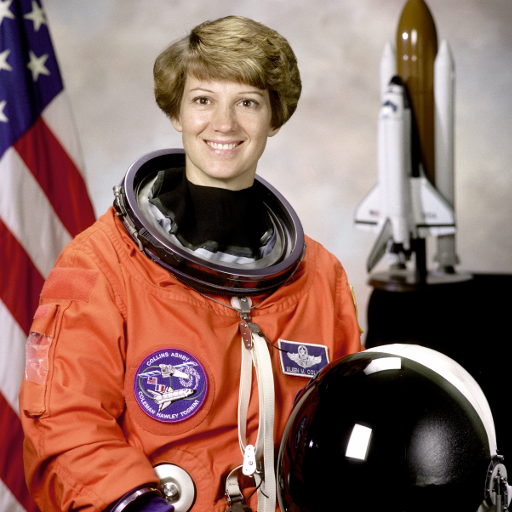



-------------------------
after transform
-------------------------


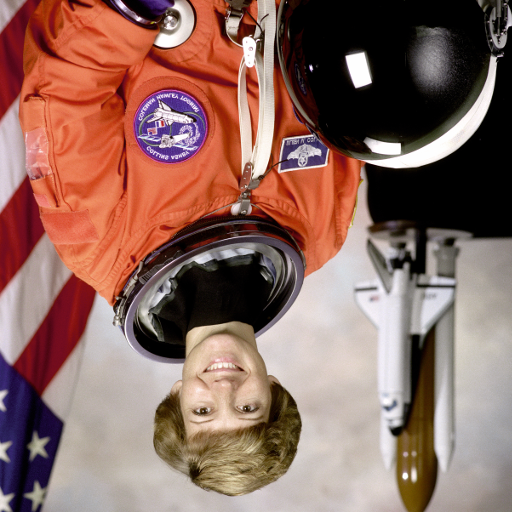

In [ ]:
from PIL import Image
from torchvision import transforms
from skimage.data import astronaut

# 이미지를 위아래로 뒤집는 변환, p=1은 100% 확률로 뒤집겠다는 뜻 (기본값은 p=0.5 → 50% 확률로 뒤집거나 그대로 둠)
vertival_flip = transforms.RandomVerticalFlip(p=1)
img = Image.fromarray(astronaut())

transformed_img = vertival_flip(img)

print("-"*25 + "\nberfore transform\n" + "-"*25)
display(img)
print("\n")
print("-"*25 + "\nafter transform\n" + "-"*25)
display(transformed_img)

### **콜백 (Callback)**

모델을 학습시키는 동안 어떤 이벤트가 발생하면 개발자가 원하는 동작을 수행할 수 있게 하는 기능으로,

대표적으로 조기 종료 (Early Stopping), 모델 체크포인트 (Model Checkpoint), 학습률 조정 (Learning Rate Scheduler) 등이 있음

#### **조기 종료 (Early Stopping)**

검증 loss가 일정 횟수(patience) 동안 개선되지 않으면 모델의 학습을 중단하는 기능으로,

모델 훈련이 조기 종료된 후에는 최적의 가중치가 복원되도록 설정할 수도 있음 </br> </br>

<img src="https://ifh.cc/g/JSw6AJ.jpg" width=350> </br> </br>

조기 종료는 검증 loss가 개선되지 않는 지점을 감지하여 학습을 조기에 멈추게 함으로써

모델이 학습 데이터를 과도하게 학습되는 것을 막아 과적합을 방지하는데 도움을 주고, 불필요한 학습 시간을 줄일 수 있음


####  **모델 체크포인트 (Model Checkpoint)**

학습 과정에서 정기적으로 모델의 가중치를 저장하는 기능으로,

학습 도중에 문제가 생겼을 때, 학습을 멈추고 저장되어있던 가중치(체크포인트)로부터 다시 학습을 이어갈 수 있음

#### **학습률 조정 (Learning Rate Scheduling)**

학습 과정에서 각 iteration별 혹은 각 epoch별로 학습률을 동적으로 변경하는 기능으로,

단계적으로 감소하는 방식, 지수적으로 감소하는 방식, 코사인 함수를 활용한 방식 등 다양한 방식으로 학습률을 조정할 수 있음 </br> </br>

<img src="https://i0.wp.com/neptune.ai/wp-content/uploads/2022/07/Learning-rate-schedulers.png?resize=981%2C603&ssl=1" width=400> </br> </br>

학습 초반에는 큰 학습률을 사용하여 빠르게 손실을 줄이고, 학습 후반으로 갈수록 학습률을 줄여 세밀한 조정과 안정적인 수렴을 도울 수 있으며,

초반에 불안정한 기울기 값으로 인해 발생하는 문제를 막기 위해

첫 학습률을 0부터 시작하여 일정 스텝까지 천천히 증가시키고 이후에는 원래 학습률 스케줄링을 따르는 Learning Rate Warmup 방법을 사용할 수 있음 </br> </br>

<img src="https://d2l.ai/_images/output_lr-scheduler_1dfeb6_135_0.svg" width=300>

**콜백 예시**

In [ ]:
import os
import torch
import torch.nn as nn

epochs = 10

num_layers = 5
model = nn.Sequential(*[nn.Sequential(nn.Linear(5,5), nn.ReLU()) for _ in range(num_layers)])
optim = torch.optim.AdamW(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)    # cosine annealing learning rate scheduler
# 학습률이 cosine 곡선을 따라 점점 감소하는 스케줄러 → 학습 후반부에서 learning rate가 천천히 줄어듦

save_steps = 2
val_loss_example = [1.0, 0.7, 0.4, 0.5, 0.3, 0.35, 0.4, 0.5, 0.6, 0.8]
min_val_loss = torch.inf
max_patience, cur_patience = 3, 0 # 연속으로 성능이 개선되지 않아도 기다리는 최대 횟수, 현재 연속된 “개선 실패 횟수”
restore_best_chekpoint = True

for epoch in range(epochs):

    """
    Trainging & Validation Code

    """

    print(f"epoch {epoch+1}")

    # learning rate scheduler
    print(f"current learning rate: {optim.state_dict()['param_groups'][0]['lr']}")
    lr_scheduler.step()

    # model checkpoint
    os.makedirs("./model", exist_ok=True) # 2 epoch마다 모델의 파라미터(state_dict)를 저장
    if (epoch + 1) % save_steps == 0:
        torch.save(model.state_dict(), f"./model/checkpoint-{epoch+1}.pth")
        print(f"saved: checkpoint-{epoch+1}.pth")

    # early stopping
    val_loss = val_loss_example[epoch]
    if val_loss < min_val_loss: # 검증 손실(val_loss)이 이전 최솟값보다 작으면 더 좋은 성능이므로 “best checkpoint”로 저장, patience 리셋
        torch.save(model.state_dict(), "./model/checkpoint-best.pth")
        if restore_best_chekpoint:
            best_sd = model.state_dict().copy()
        min_val_loss = val_loss
        cur_patience = 0
    else:
        cur_patience += 1 # patience 리셋
    print(f"validataion loss: {val_loss}  current patience: {cur_patience}")

    print("-"*20 + "\n")

    if max_patience == cur_patience: # max_patience=3에 도달하면 → 학습 중단
        if restore_best_chekpoint:
            model.load_state_dict(best_sd)
        print("-"*20 + "\nEarly Stopping!\n" + "-"*20)
        break

epoch 1
current learning rate: 0.001
validataion loss: 1.0  current patience: 0
--------------------

epoch 2
current learning rate: 0.0009755282581475768
saved: checkpoint-2.pth
validataion loss: 0.7  current patience: 0
--------------------

epoch 3
current learning rate: 0.0009045084971874736
validataion loss: 0.4  current patience: 0
--------------------

epoch 4
current learning rate: 0.0007938926261462366
saved: checkpoint-4.pth
validataion loss: 0.5  current patience: 1
--------------------

epoch 5
current learning rate: 0.0006545084971874737
validataion loss: 0.3  current patience: 0
--------------------

epoch 6
current learning rate: 0.0005
saved: checkpoint-6.pth
validataion loss: 0.35  current patience: 1
--------------------

epoch 7
current learning rate: 0.00034549150281252633
validataion loss: 0.4  current patience: 2
--------------------

epoch 8
current learning rate: 0.0002061073738537635
saved: checkpoint-8.pth
validataion loss: 0.5  current patience: 3
-----------

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
